# A/B Testing - Analysis of the Effectiveness of Two Landing Page Variants

## Import dependencies

In [182]:
import pandas as pd
import plotly.express as px

from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import t
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

pd.options.mode.chained_assignment = None

## Load data

In [183]:
data = pd.read_csv('../../data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Add a feature of tour destination.

In [184]:
def get_tour_type(price):
    result = ''
    
    if price == 100000:
        result = 'Thailand'
    elif price == 60000:
        result = 'Turkey'
    elif price == 200000:
        result = 'Maldives'
    elif price == 10000:
        result = 'St. Petersburg'
    elif price == 150000:
        result = 'Kamchatka'

    return result


data['destination'] = data['price'].apply(lambda price: get_tour_type(price))

## Exploratory data analysis

### Preliminary data analysis

In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      294478 non-null  int64 
 1   date         294478 non-null  object
 2   group        294478 non-null  object
 3   purchase     294478 non-null  int64 
 4   price        294478 non-null  int64 
 5   destination  294478 non-null  object
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


All columns have a correct data type except or the column 'date'. We need to convert the 'date' column to Datetime data type to perform operations with dates.

In [186]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      294478 non-null  int64         
 1   date         294478 non-null  datetime64[ns]
 2   group        294478 non-null  object        
 3   purchase     294478 non-null  int64         
 4   price        294478 non-null  int64         
 5   destination  294478 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.5+ MB


Check the duration of the test interval for both groups.

In [187]:
group_a_start = data[data['group'] == 'A']['date'].dt.date.min()
group_a_end = data[data['group'] == 'A']['date'].dt.date.max()
group_b_start = data[data['group'] == 'B']['date'].dt.date.min()
group_b_end = data[data['group'] == 'B']['date'].dt.date.max()

print(f'Grop A test interval: {group_a_start} - {group_a_end}')
print(f'Grop B test interval: {group_b_start} - {group_b_end}')

Grop A test interval: 2021-01-02 - 2021-01-24
Grop B test interval: 2021-01-02 - 2021-01-24


Test intervals are identical for both test groups. No action is required to equalize the test intervals.

Check for empty values.

In [188]:
data.isnull().sum()

user_id        0
date           0
group          0
purchase       0
price          0
destination    0
dtype: int64

There are no empty values in data.

Check if there are users who got into both groups during the test.

In [189]:
user_group_count = data.groupby('user_id')['group'].count().reset_index()
users_in_both_groups = user_group_count[user_group_count['group'] != 1]
print('Number of users present in both groups:', users_in_both_groups.shape[0])

# We need to delete these users from the dataset.
print('Total test data:', data.shape[0])
users_in_both_groups = users_in_both_groups['user_id'].to_list()
data = data[~data['user_id'].isin(users_in_both_groups)]
print('Total test data after deletion:', data.shape[0])

Number of users present in both groups: 3894
Total test data: 294478
Total test data after deletion: 286690


### Basic data analysis

For both groups count the number of website visits, number of purchases, total amount of all purchases.

In [190]:
visits_a = data[data['group'] == 'A'].shape[0]
visits_b = data[data['group'] == 'B'].shape[0]

num_purchases_a = data[data['group'] == 'A']['purchase'].sum()
num_purchases_b = data[data['group'] == 'B']['purchase'].sum()

total_purchase_a = data[data['group'] == 'A']['price'].sum()
total_purchase_b = data[data['group'] == 'B']['price'].sum()

print('Grouop\t\tVisits\t\tPurchases\tSum')
print(f'A\t\t{visits_a}\t\t{num_purchases_a}\t\t{total_purchase_a}')
print(f'B\t\t{visits_b}\t\t{num_purchases_b}\t\t{total_purchase_b}')

Grouop		Visits		Purchases	Sum
A		143293		17220		1396120000
B		143397		17025		1510100000


The groups A and B are balanced based on the number of visits: 143293 vs 143397.

Group A shows a slight higher number of purchases, where group B shows a higher total amount of all purchases.

Calculate conversion rate and average bill for both groups.

In [191]:
conversion_a = num_purchases_a / visits_a
conversion_b = num_purchases_b / visits_b

average_bill_a = total_purchase_a / num_purchases_a
average_bill_b = total_purchase_b / num_purchases_b

print('Group\t\tConversion rate\t\tAverage bill')
print(f'A\t\t{conversion_a.round(4)}\t\t\t{average_bill_a.round(2)}')
print(f'B\t\t{conversion_b.round(4)}\t\t\t{average_bill_b.round(2)}')

Group		Conversion rate		Average bill
A		0.1202			81075.49
B		0.1187			88698.97


Based on the numbers obtained above:
* Group A has a slightly higher conversion (0.15 %)
* Group B has a higher average bill (9 %)

Calculate purchasing power for each of the destinations in both groups.

In [192]:
purchasing_power = data.groupby(['group', 'destination', 'price'])['purchase'].sum().reset_index()

purchasing_power[purchasing_power['purchase'] != 0]

,group,destination,price,purchase
1,A,Kamchatka,150000,3430
2,A,Maldives,200000,1691
3,A,St. Petersburg,10000,5096
4,A,Thailand,100000,1807
5,A,Turkey,60000,5196
7,B,Kamchatka,150000,3388
8,B,Maldives,200000,1671
9,B,St. Petersburg,10000,5118
10,B,Thailand,100000,5141
11,B,Turkey,60000,1707


Purchasing power analysis per destination suggests that groups A and B are more ore less similar in terms of such destinations as Kamchatka, Maldives and St. Petersburg, but for Thailand and Turkey they are opposite (group A has approximately triple Turkey compared to Thailand, group B has triple Thailand compared to Turkey).

### Analyze data in terms of metric stabilization

Group data by group and date. For each group calculate number of visits, number of purchases and total amount of purchases.

Then add information for the daily conversion rate and average bill.

In [193]:
group_metrics = data.groupby(['group', 'date']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={'user_id': 'visits', 'price': 'total_amount'})

group_metrics['conversion_rate'] = group_metrics['purchase'] / group_metrics['visits']
group_metrics['average_bill'] = group_metrics['total_amount'] / group_metrics['purchase']

print(group_metrics.head())

  group       date  visits  purchase  total_amount  conversion_rate  \
0     A 2021-01-02    2813       354      29170000         0.125844   
1     A 2021-01-03    6494       738      61420000         0.113643   
2     A 2021-01-04    6481       787      63050000         0.121432   
3     A 2021-01-05    6330       780      63460000         0.123223   
4     A 2021-01-06    6518       750      62460000         0.115066   

   average_bill  
0  82401.129944  
1  83224.932249  
2  80114.358323  
3  81358.974359  
4  83280.000000  


Based on the data above we will calculate the cumulative statistics on the group data: cumulative conversion rate and cumulateive average bill in both groups.

Represent the calculated cumulative values as diagrams.

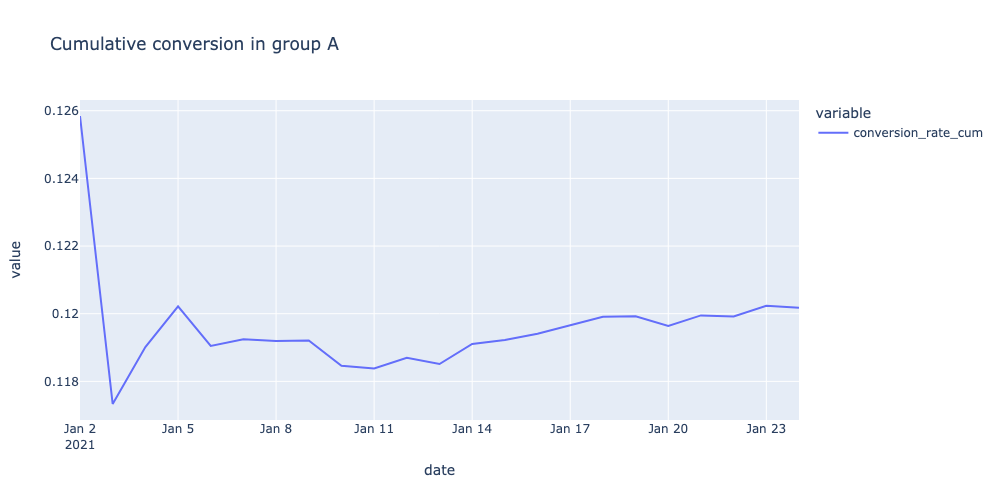

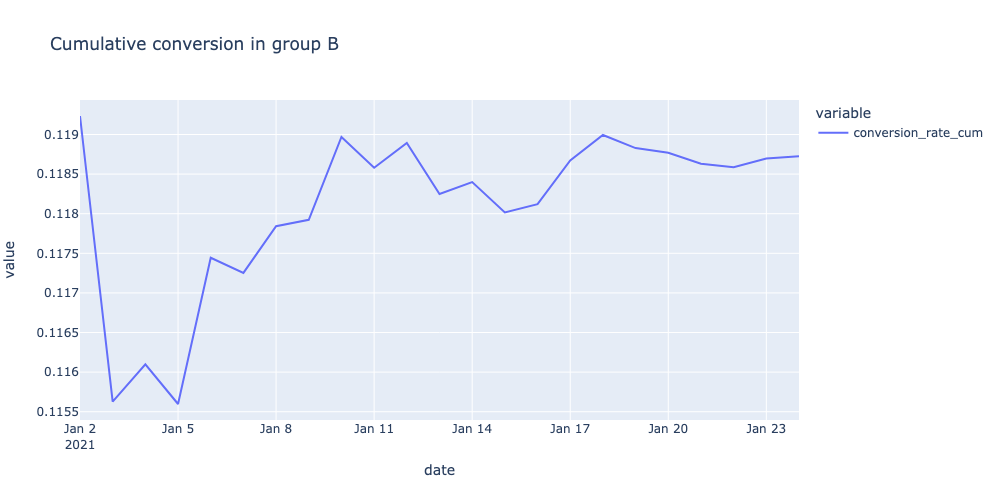

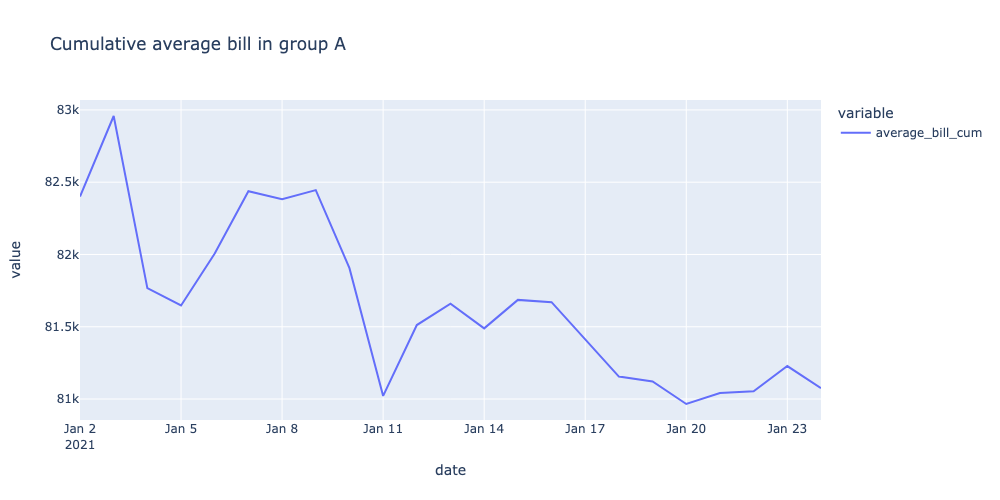

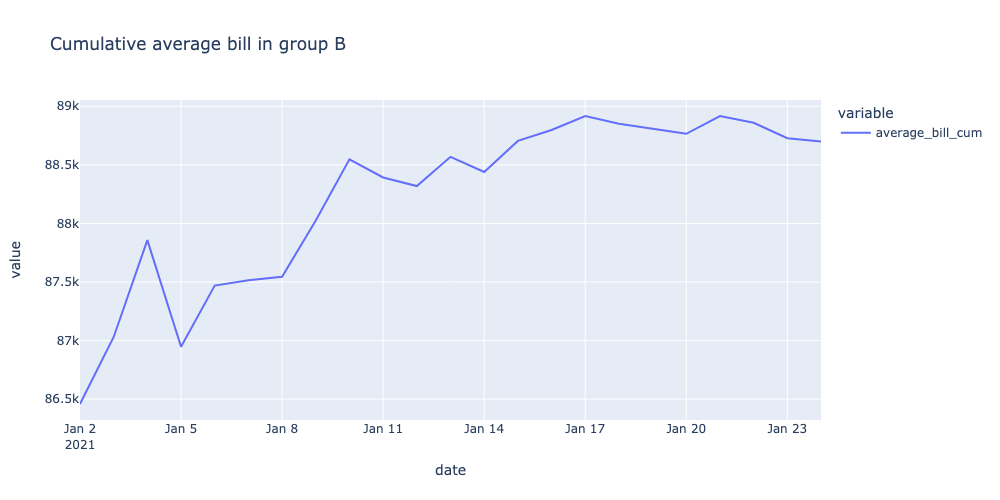

In [194]:
group_metrics_a = group_metrics[group_metrics['group'] == 'A']
group_metrics_b = group_metrics[group_metrics['group'] == 'B']

group_metrics_a[['visits_cum', 'purchase_cum', 'total_amount_cum']] = \
    group_metrics_a[['visits', 'purchase', 'total_amount']].cumsum()
group_metrics_b[['visits_cum', 'purchase_cum', 'total_amount_cum']] = \
    group_metrics_b[['visits', 'purchase', 'total_amount']].cumsum()

group_metrics_a['conversion_rate_cum'] = group_metrics_a['purchase_cum'] / group_metrics_a['visits_cum']
group_metrics_a['average_bill_cum'] = group_metrics_a['total_amount_cum'] / group_metrics_a['purchase_cum']
group_metrics_b['conversion_rate_cum'] = group_metrics_b['purchase_cum'] / group_metrics_b['visits_cum'] 
group_metrics_b['average_bill_cum'] = group_metrics_b['total_amount_cum'] / group_metrics_b['purchase_cum']

def show_metric_diagram(group_metrics, metric_name, diagram_title):
    fig = px.line(
        group_metrics, 
        x='date', 
        y=[metric_name],
        width=1000,
        height=500,
        title=diagram_title
    )
    fig.show('png')
    

show_metric_diagram(group_metrics_a, 'conversion_rate_cum', 'Cumulative conversion in group A')
show_metric_diagram(group_metrics_b, 'conversion_rate_cum', 'Cumulative conversion in group B')
show_metric_diagram(group_metrics_a, 'average_bill_cum', 'Cumulative average bill in group A')
show_metric_diagram(group_metrics_b, 'average_bill_cum', 'Cumulative average bill in group B')

The values in of the conversion rate form a line at the end of the interval, it means that the values have stabilized. The values of the average bill have not stabilized, because they are represented as a polygonal line. This indicates that the test has not been completed.

### Statistic analysis of test results

#### Statistic tests

Set statistic hypothesis for conversion rate and average bill.
* Conversion rate:
H0: pa = pb; H1: pa <> pb - Z-test will be used
* Average bill: we need to identify if the data is normally distributed and pick a statistic test based on that. We'll use the Shapiro-Wilk test for that.

In [195]:
alpha = 0.05 # We pick the confidence level 5 %

shapiro_result_a = shapiro(group_metrics_a['average_bill'])
shapiro_result_b = shapiro(group_metrics_b['average_bill'])

print('p-value in group A', shapiro_result_a.pvalue.round(2))
print('p-value in group B', shapiro_result_b.pvalue.round(2))

if shapiro_result_a.pvalue <= alpha:
    print('Average bill distribution in group A is not normal')
else:
    print('Average bill distribution in group A is normal')
if shapiro_result_b.pvalue <= alpha:
    print('Average bill distribution in group B is not normal')
else:
    print('Average bill distribution in group B is normal')


p-value in group A 0.31
p-value in group B 0.11
Average bill distribution in group A is normal
Average bill distribution in group B is normal


The average bill data has normal distribution in both groups and the groups are independent (this has been ensured above). Our test is T-test.

H0: pa = pb; H1: pa <> pb

First we'll perform the statistic test for the conversion rate.

In [196]:
group_conversion = data.groupby('group')['purchase'].agg(['sum', 'count'])

_, p_value = proportions_ztest(
    count=group_conversion['sum'],
    nobs=group_conversion['count'],
    alternative='two-sided'
)

print('p-value: ', p_value.round(2))

if (p_value <= alpha):
    print('H0 can be rejected in favor of H1')
else:
    print('There is no reason to reject H0')

p-value:  0.23
There is no reason to reject H0


H0 hypothesis cannot be rejected, this means that the statistic test has shown that the conversion rate in both groups is statistically the same.

Let's perform the statistic test for the average bill.

In [197]:
results = ttest_ind(
    a=group_metrics_a['average_bill'],
    b=group_metrics_b['average_bill'],
    alternative='two-sided'
)

print('p-value: ', results.pvalue)

if (results.pvalue <= alpha):
    print('H0 can be rejected in favor of H1')
else:
    print('There is no reason to reject H0')

p-value:  1.4658248761016225e-12
H0 can be rejected in favor of H1


The statistic test has shown that the average bill in group B is statistically different from the average bill in group A. Let's check the right-sided alternative hypothesis:

H0: pa <= pb; H1: pa > pb

In [198]:
results = ttest_ind(
    a=group_metrics_a['average_bill'],
    b=group_metrics_b['average_bill'],
    alternative='greater'
)

print('p-value: ', results.pvalue)

if (results.pvalue <= alpha):
    print('H0 can be rejected in favor of H1')
else:
    print('There is no reason to reject H0')

p-value:  0.999999999999267
There is no reason to reject H0


H0 cannot be rejected, which means that checking both two-sided and right-sided alternative hypothesis the average bill is statistically larger in the group B.

#### Confidence intervals

First we'll calculate the confidence interval for conversion rates in both groups and the difference of conversion rates in the groups.

In [199]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return lower_bound, upper_bound

def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma 
    diff = x_p[1] - x_p[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return lower_bound, upper_bound


lower_bound_a, upper_bound_a  = proportion_conf_interval(
    group_metrics_a['conversion_rate'].mean(), visits_a
)
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    group_metrics_b['conversion_rate'].mean(), visits_b
)

print('Confidence interval of conversion rate in group A:', round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))
print('Confidence interval of conversion rate in group B:', round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))

x_p = [group_metrics_a['conversion_rate'].mean(), group_metrics_b['conversion_rate'].mean()]
n = [visits_a, visits_b]
lower_bound, upper_bound = diff_proportion_conf_interval(x_p, n)
print('Confidence interval of conversion rates differences:', round(lower_bound*100, 2), round(upper_bound*100, 2))



Confidence interval of conversion rate in group A: 11.86 12.2
Confidence interval of conversion rate in group B: 11.71 12.04
Confidence interval of conversion rates differences: -0.39 0.08


Confidence intervals of conversion rate in groups A and B have an intersection between [11.86; 12.04]. This means that we cannot say definitely that conversions in the groups are different. Confidence interval of the difference includes 0, which means that there is no statistical difference between the conversion rates in the groups A and B.

Let's calculate the confidence intervals for the average bill in the both groups.

In [200]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    k = n - 1
    alpha = 1 - gamma 
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std/(n ** 0.5) 
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    return lower_bound, upper_bound


lower_bound_a, upper_bound_a = t_mean_conf_interval(
    group_metrics_a['average_bill'].mean(), 
    group_metrics_a['average_bill'].std(), 
    group_metrics_a.shape[0]
)
lower_bound_b, upper_bound_b = t_mean_conf_interval(
    group_metrics_b['average_bill'].mean(), 
    group_metrics_b['average_bill'].std(), 
    group_metrics_b.shape[0]
)
print('Confidence interval of average bill in group A:', round(lower_bound_a), round(upper_bound_a))
print('Confidence interval of average bill in group B:', round(lower_bound_b), round(upper_bound_b))

Confidence interval of average bill in group A: 79626 82339
Confidence interval of average bill in group B: 87726 89516


Confidence interval of the average bill in group B is not intersecting with the confidence interval of the group A. If we put both confidence interval on an axis, the confidence interval of the group B will be to the right of the confidence interval of the group A. This means that the average bill in the group B is statistically larger than in the group A.

## Conclusion

Based on the statistic tests and analysis of confidence intervals I can state that:
* The conversion rates in both groups are statistically the same.
* The average bill in the the group B is larger than in the group A. Although it must be noted that the cumulative average bill has not stabilized and it would make sense to prolong the test for more accurate results.